## Complex initialization

In MACE, the central entity is a `Complex` object. It can be generated from SMILES of the metal complex, from SMILES of ligands and a central atom, and from a MACE-generated `.xyz` file.

In [1]:
# use current mace version
import sys, os
sys.path.insert(0, os.path.abspath('../../../'))

# imports
import mace, py3Dmol

# view 3D structures
def view_complex(X, confId = 0):
    '''Shows molecule corresponding to the SMILES'''
    view = py3Dmol.view()
    view.addModel(X.ToXYZBlock(confId = confId), 'xyz')
    view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.3}})
    view.setBackgroundColor('white')
    view.zoomTo()
    view.show()

### Direct initialization

The `Complex`'s class constructore takes as input (1) SMILES of the metal complex and (2) the molecular geometry of the central atom (`"OH"` for octahedral, and `"SP"` for square-planar). SMILES must satisfy the following conditions:

1. Donor atoms of ligands have non-zero atomic map number: 1-6 for octahedral and 1-4 for square-planar geometries. Atomic map numbers are used to detect donor atoms and to describe a spatial arrangement of ligands around a central atom:

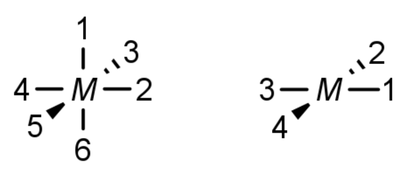

2. Other atoms have unspecified atomic map number and isotopic number, except where otherwise noted (see the "Adding substituents" subsection);

3. Bonds between central atom and ligands are dative;

4. The complex contains one central atom only.

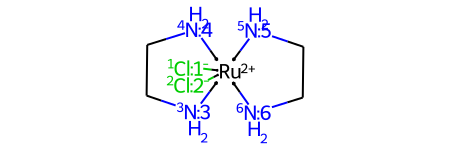

In [2]:
# get complex
smiles = '[Cl-:1]->[Ru+2](<-[Cl-:2])(<-[NH2:3]CC1)(<-[NH2:4]1)(<-[NH2:5]CC1)(<-[NH2:6]1)'
X = mace.Complex(smiles = smiles, geom = 'OH')
X.mol

### Issue of resonance structures

The `maxResonanceStructures` argument can be ignored in most cases. It is needed for complexes containing symmetrical multidentate ligands with an asymmetric arrangement of multiple bonds in the resonance structure used in the SMILES string, e.g. dithiocarboxylates. Indeed, in both sulfur atoms in `CC(=S)[S-]` are identical, even though in molecular graph one atom forms a single bond and the other forms a double bond. When such ligands will act as bidentate ligands, there are possibility that the final set of isomers will contain identical systems:

In [3]:
# get isomers
smiles = '[Pd+2](<-[S-:1]1)(<-[S:2]=C1C)(<-[S-:3]1)(<-[S:4]=C1C)'
X1 = mace.Complex(smiles, 'SP', maxResonanceStructures = 1)
X1_isomers = X1.GetStereomers()
len(X1_isomers)

2

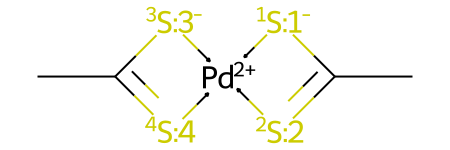

In [4]:

X1_isomers[0].mol

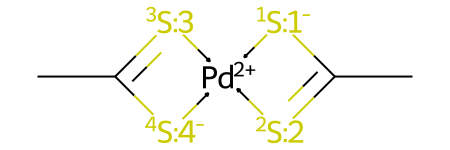

In [5]:
# 2nd isomer
X1_isomers[1].mol

In MACE this problem is solved for carboxylates and NCN-carbenes, but for other systems one should use `maxResonanceStructures` parameter during `Complex` initialization. It is a number of resonance structures which will be considered for the complex during generation of a data structure for isomers' comparison. The larger its value, the higher the probability of filtering duplicated stereomers:

In [6]:
# get isomers with maxResonanceStructures > 1
X2 = mace.Complex(smiles, 'SP', maxResonanceStructures = 4)
X2_isomers = X2.GetStereomers()
len(X2_isomers)

1

However, such approach can be extremely time consuming for large conjugated systems.

### Complex from ligands

The other way to generate the `Complex` object is to generate it from the ligands:

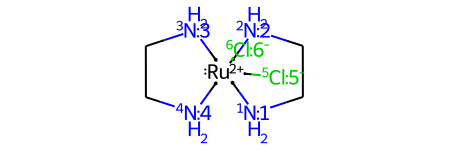

In [7]:
# get complex from ligands
ligands = ['[NH2:1]CC[NH2:2]', '[NH2:3]CC[NH2:4]', '[Cl-:5]', '[Cl-:6]']
X = mace.ComplexFromLigands(ligands = ligands, CA = '[Ru+2]', geom = 'OH')
X.mol

Note that the stereochemistry of the central atom can be specified in the ligands, since the map numbers are preserved during the initialization of a complex.

### Complex from xyz-file

Finally, `Complex` can be read from MACE-generated `xyz`-file. Please note, that is possible if only `Complex` has at least one conformer:

In [8]:
# generate several conformers, view 1st
X.AddConformers(numConfs = 5)
print(f'Number of generated conformers: {X.GetNumConformers()}')
view_complex(X)

Number of generated conformers: 5


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [9]:
# save xyz
path = 'Ru_NN2_Cl2.xyz'
X.ToXYZ(path)

# read it as text
with open(path, 'r') as inpf:
    for _ in range(10):
        print(inpf.readline(), end = '')
    print('...')

27
{"conf": 0, "E": 13.23, "rms": -1.0, "geom": "OH", "total_charge": 0, "CA_charge": 2, "smiles": "[1NH2]1->[Ru+2:10]2(<-[5Cl-:8])(<-[6Cl-:9])(<-[2NH2:3][CH2:2][CH2:1]1)<-[3NH2:4][CH2:5][CH2:6][4NH2:7]->2", "smiles3D": "[1N]1([H:11])([H:12])->[Ru+2:10]2(<-[5Cl-:8])(<-[6Cl-:9])(<-[2N:3]([H:17])([H:18])[C:2]([H:15])([H:16])[C:1]1([H:13])[H:14])<-[3N:4]([H:19])([H:20])[C:5]([H:21])([H:22])[C:6]([H:23])([H:24])[4N:7]->2([H:25])[H:26]", "smiles3Dx": "[1N]1([H:11])([H:12])->[Ru+2:10]2(<-[5Cl-:8])(<-[6Cl-:9])(<-[2N:3]([H:17])([H:18])[C:2]([H:15])([H:16])[C:1]1([H:13])[H:14])<-[3N:4]([H:19])([H:20])[C:5]([H:21])([H:22])[C:6]([H:23])([H:24])[4N:7]->2([H:25])[H:26]", "dummies": []}
N     -0.0399     1.5736    -1.4290
C     -1.2985     2.1581    -1.3389
C     -2.3871     1.0967    -1.0811
N     -2.0926     0.3426     0.0474
N      0.3703     1.3933     1.5625
C      1.7273     1.6930     1.5121
C      2.5588     0.4456     1.1505
N      2.1171    -0.1224    -0.0375
...


The second line of the file contains JSON with information required to regenerate `Complex` object, thus `Complex` can be initialized from `mace`-generated xyz-files **only**:

In [10]:
# load xyz and view 1st conf
X = mace.ComplexFromXYZFile(path)
print(f'Number of generated conformers: {X.GetNumConformers()}')
view_complex(X)

Number of generated conformers: 5


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [11]:
# remove file
import os
os.remove(path)